# Bottle Label Classification Model Training

## Project Overview
This notebook implements a YOLO classification model to detect bottle label quality for a Raspberry Pi 5 based labeling machine.

**Classes:**
1. `correct_label`
2. `misaligned_label`
3. `no_label`

**Goal:** Achieve maximum accuracy and export to ONNX for edge deployment.

## 1. Environment Setup & Dependencies
Installing required libraries for YOLOv8/v11, dataset management, and visualization.

In [1]:
# Install dependencies
%pip install ultralytics roboflow onnx onnxruntime matplotlib seaborn scikit-learn pandas opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# Configuration
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Check Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

# Verify Ultralytics
import ultralytics
print(f"Ultralytics version: {ultralytics.__version__}")

Using device: mps
Ultralytics version: 8.3.235


## 2. Dataset Analysis & Exploration
Analyzing the dataset structure, class distribution, and image quality.

In [3]:
# Define dataset path
dataset_path = Path("bottle_classification_augmented")
train_path = dataset_path / "train"
valid_path = dataset_path / "valid"
test_path = dataset_path / "test"

# Function to count images
def count_images(path):
    counts = {}
    if not path.exists():
        return counts
    for class_dir in path.iterdir():
        if class_dir.is_dir():
            # Count common image formats
            count = len(list(class_dir.glob("*.jpg"))) + len(list(class_dir.glob("*.jpeg"))) + len(list(class_dir.glob("*.png")))
            counts[class_dir.name] = count
    return counts

train_counts = count_images(train_path)
valid_counts = count_images(valid_path)
test_counts = count_images(test_path)

print("Train counts:", train_counts)
print("Valid counts:", valid_counts)
print("Test counts:", test_counts)

Train counts: {'no_label': 210, 'correct_label': 210, 'misaligned_label': 210}
Valid counts: {'no_label': 60, 'correct_label': 60, 'misaligned_label': 60}
Test counts: {'no_label': 30, 'correct_label': 30, 'misaligned_label': 30}


       no_label  correct_label  misaligned_label
Train       210            210               210
Valid        60             60                60
Test         30             30                30


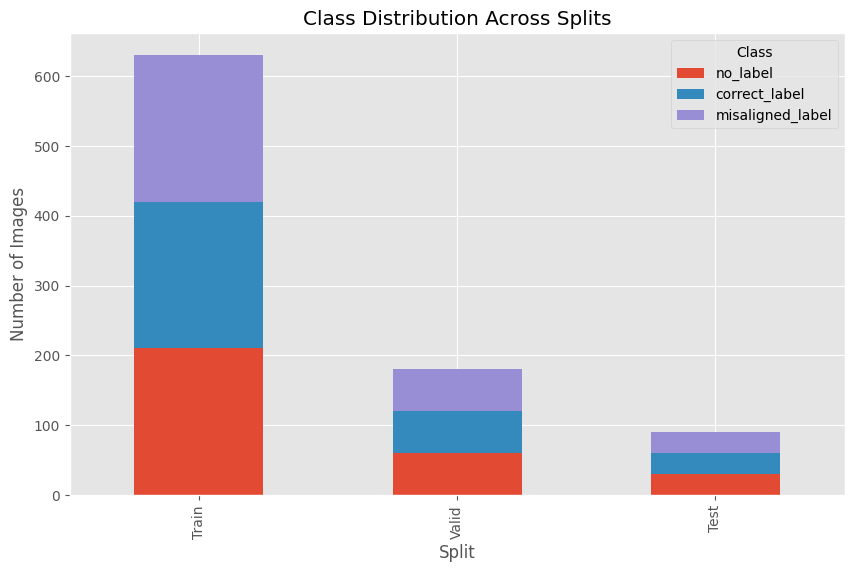

In [4]:
# Visualize Class Distribution
all_counts = pd.DataFrame([train_counts, valid_counts, test_counts], index=['Train', 'Valid', 'Test']).fillna(0)
print(all_counts)

all_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Class Distribution Across Splits")
plt.ylabel("Number of Images")
plt.xlabel("Split")
plt.legend(title="Class")
plt.show()

Training Samples:


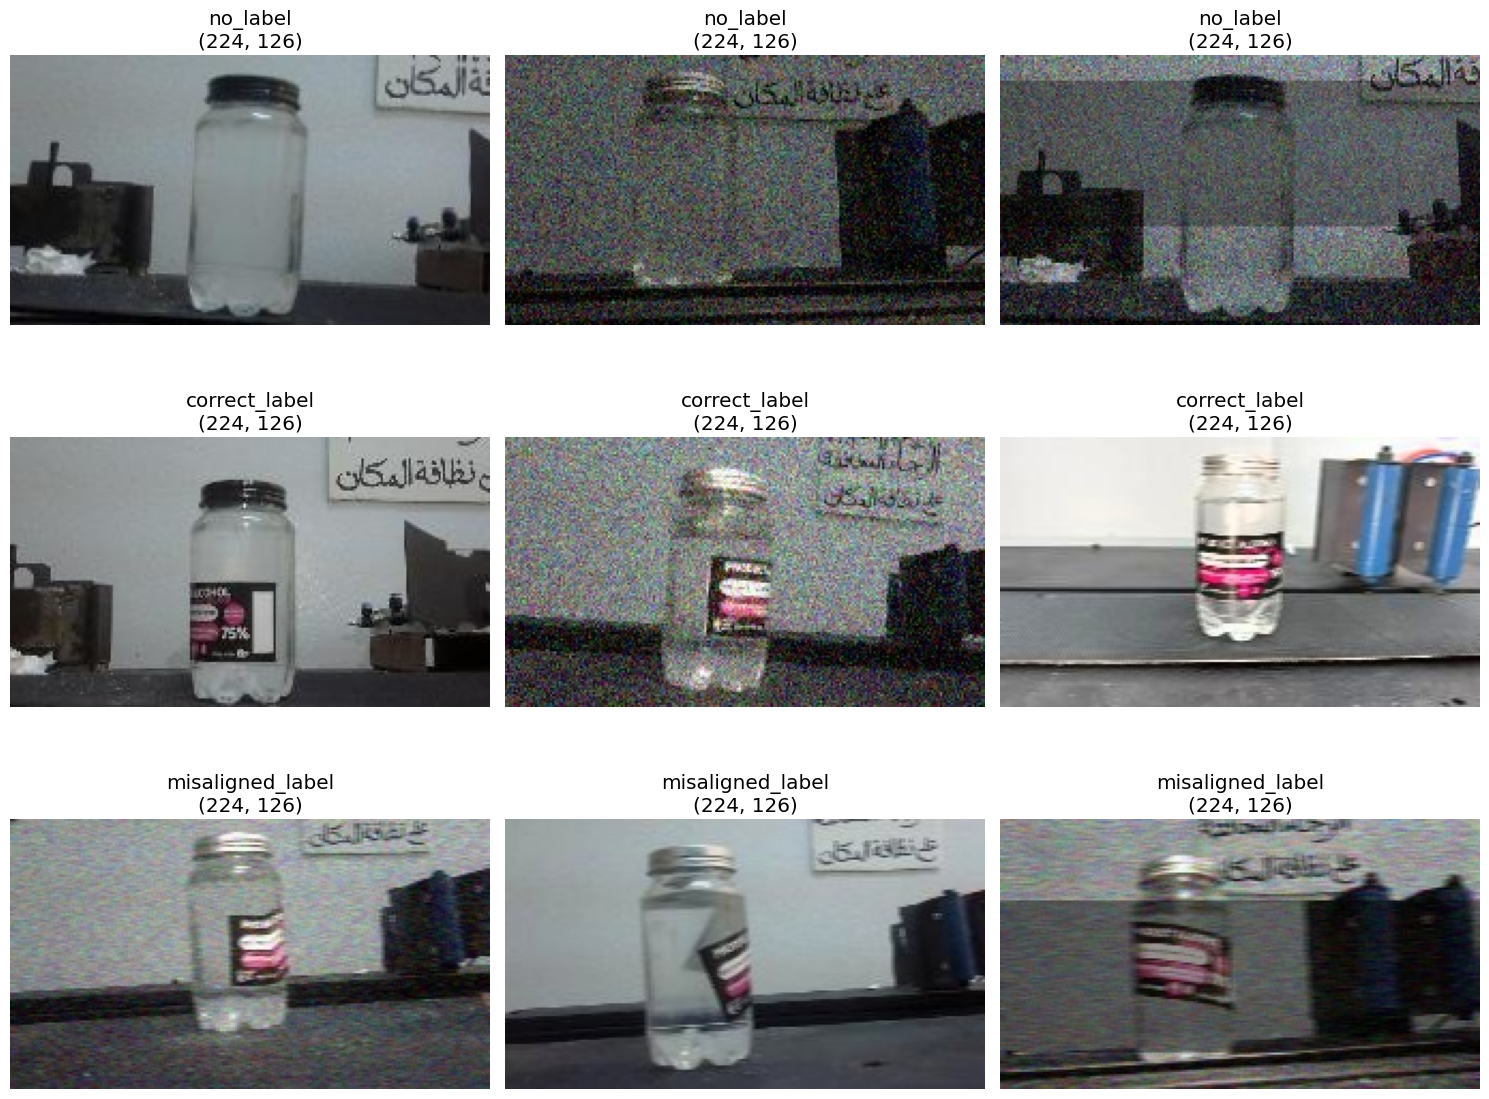

In [5]:
# Display Sample Images
def show_samples(path, num_samples=3):
    classes = [d.name for d in path.iterdir() if d.is_dir()]
    # Calculate grid size
    n_classes = len(classes)
    if n_classes == 0:
        print("No classes found to display.")
        return
        
    fig, axes = plt.subplots(n_classes, num_samples, figsize=(15, 4*n_classes))
    if n_classes == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, cls in enumerate(classes):
        cls_path = path / cls
        images = list(cls_path.glob("*.jpg")) + list(cls_path.glob("*.jpeg")) + list(cls_path.glob("*.png"))
        
        if not images:
            continue
            
        selected = np.random.choice(images, min(len(images), num_samples), replace=False)
        
        for j, img_path in enumerate(selected):
            img = Image.open(img_path)
            ax = axes[i, j]
            ax.imshow(img)
            ax.set_title(f"{cls}\n{img.size}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Training Samples:")
show_samples(train_path)

## 3. Model Training
Training YOLOv8n-cls and YOLOv11n-cls models. We start with the 'nano' models which are optimized for edge devices like Raspberry Pi.

In [6]:
# Define project name for saving results
project_name = "bottle_classification"

# --- YOLOv8 Nano Training ---
print("Starting YOLOv8n-cls training...")
model_v8 = YOLO('yolov8n-cls.pt') 

results_v8 = model_v8.train(
    data=str(dataset_path.absolute()),
    epochs=50,           # Adjust based on convergence needs
    imgsz=224,           # Standard size for classification
    batch=16,            # Adjust based on GPU memory
    project=project_name,
    name='yolov8n_run',
    device=device,
    patience=10,         # Early stopping
    augment=True         # Use default augmentations
)

Starting YOLOv8n-cls training...
Ultralytics 8.3.235 🚀 Python-3.13.0 torch-2.9.1 MPS (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_run, nbs=64, nms=False, opset=None, optim

In [19]:
# --- YOLOv11 Nano Training (Optional Comparison) ---
# If you want to compare performance with the newer YOLOv11 architecture
try:
    print("Starting YOLO11n-cls training...")
    model_v11 = YOLO('yolo11n-cls.pt')
    results_v11 = model_v11.train(
        data=str(dataset_path.absolute()),
        epochs=50,
        imgsz=224,
        batch=16,
        project=project_name,
        name='yolo11n_run',
        device=device,
        patience=10,
        augment=True
    )
except Exception as e:
    print(f"YOLOv11 training skipped or failed: {e}")

Starting YOLO11n-cls training...
Ultralytics 8.3.235 🚀 Python-3.13.0 torch-2.9.1 MPS (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle classification.v7-version-5.folder, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_run, nbs=64, nms=False, opset=N

## 4. Validation & Evaluation
Evaluating the best performing model on the test set to verify accuracy and robustness.

In [7]:
# Select the best model (Update path if you prefer the v11 model)
best_model_path = Path(project_name) / "yolov8n_run" / "weights" / "best.pt"
print(f"Loading model from: {best_model_path}")

if best_model_path.exists():
    model = YOLO(best_model_path)
    
    # Validate on validation set (built-in method)
    metrics = model.val()
    print(f"Top-1 Accuracy: {metrics.top1}")
    print(f"Top-5 Accuracy: {metrics.top5}")
else:
    print("Model weights not found. Please ensure training completed successfully.")

Loading model from: bottle_classification/yolov8n_run/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.13.0 torch-2.9.1 CPU (Apple M1 Pro)
YOLOv8n-cls summary (fused): 30 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented/train... found 630 images in 3 classes ✅ 
val: /Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented/valid... found 180 images in 3 classes ✅ 
test: /Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented/test... found 90 images in 3 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 498.7±302.6 MB/s, size: 15.4 KB)
val: Scanning /Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented/valid... 180 images, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 605.9Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 12/1

Running predictions on Test Set...

0: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
1: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
2: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
3: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
4: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
5: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
6: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
7: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
8: 224x224 no_label 1.00, misaligned_label 0.00, correct_label 0.00, 15.8ms
9: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
10: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
11: 224x224 no_label 1.00, correct_label 0.00, misaligned_label 0.00, 15.8ms
12: 224x224 no_label 1.00, correct_label 0.00, mis

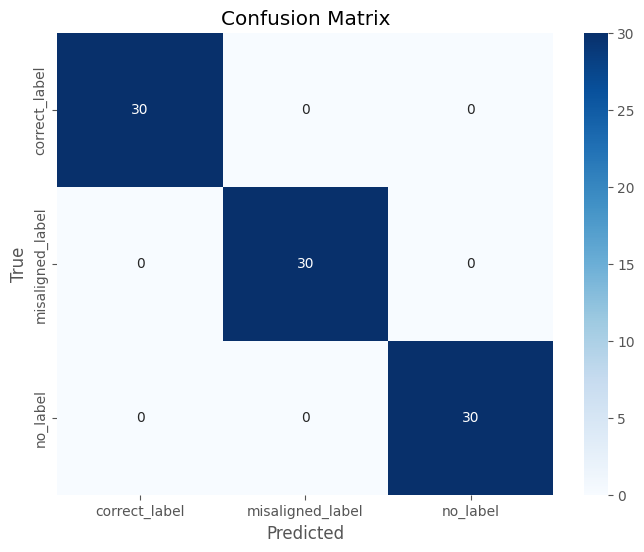

In [8]:
# Detailed Evaluation on Test Set
if best_model_path.exists():
    print("Running predictions on Test Set...")
    
    # FIX: Explicitly collect image paths recursively
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    test_images = [str(p) for p in test_path.rglob('*') if p.suffix.lower() in image_extensions]
    
    if not test_images:
        print(f"No images found in {test_path}")
    else:
        # Pass the list of images instead of the directory path
        test_results = model.predict(test_images, stream=True)

        y_true = []
        y_pred = []
        class_names = model.names

        for result in test_results:
            # Extract true class from path (assuming folder structure: test/class_name/image.jpg)
            path_obj = Path(result.path)
            true_label = path_obj.parent.name
            
            # Prediction
            pred_label_idx = result.probs.top1
            pred_label = class_names[pred_label_idx]
            
            y_true.append(true_label)
            y_pred.append(pred_label)

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(class_names.values()))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names.values(), yticklabels=class_names.values(), cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
else:
    print("Skipping evaluation as model not found.")

## 5. Model Export
Exporting to ONNX format for Raspberry Pi 5 deployment. We use `opset=12` for broad compatibility.

In [9]:
if best_model_path.exists():
    # Export to ONNX
    export_path = model.export(format='onnx', imgsz=224, dynamic=False, opset=12)
    print(f"Model exported to: {export_path}")
    
    # Optional: Verify ONNX model with ONNX Runtime
    import onnxruntime as ort
    try:
        ort_session = ort.InferenceSession(export_path)
        print("ONNX model loaded successfully with ONNX Runtime.")
    except Exception as e:
        print(f"Failed to load ONNX model: {e}")
else:
    print("Skipping export.")

Ultralytics 8.3.235 🚀 Python-3.13.0 torch-2.9.1 CPU (Apple M1 Pro)

PyTorch: starting from 'bottle_classification/yolov8n_run/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 3) (2.8 MB)

ONNX: starting export with onnx 1.19.1 opset 12...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 0.3s, saved as 'bottle_classification/yolov8n_run/weights/best.onnx' (5.5 MB)

Export complete (0.4s)
Results saved to /Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification/yolov8n_run/weights
Predict:         yolo predict task=classify model=bottle_classification/yolov8n_run/weights/best.onnx imgsz=224  
Validate:        yolo val task=classify model=bottle_classification/yolov8n_run/weights/best.onnx imgsz=224 data=/Users/mabdulrafea/Projects/hareem_tasks/libiya-rasberry-pi-makeen/bottle_classification_augmented  
Visualize:       https://netron.app
Model exported to: bottle_classification/yolov8n_run/weights/best.onnx
ONNX 

## 6. Deployment Notes
To run this on Raspberry Pi 5:
1. Transfer the `.onnx` file to the Pi.
2. Install `onnxruntime` (or `onnxruntime-gpu` if using an accelerator, though Pi 5 is CPU/VideoCore).
3. Use the provided inference script in the plan to run detection on the camera feed.

## 7. Verification & Live Prediction
Verify the model using custom images or a live camera feed. This section uses the exported ONNX models.

In [10]:
# --- Load Required Libraries for Inference ---
import onnxruntime as ort
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import io

project_name = "bottle_classification" # Ensure this matches training

# Check Class Names (typically defined during training)
# If you ran the training cells above, 'model.names' might be available.
# Otherwise, defining manually based on the dataset structure.
class_names = {0: 'correct_label', 1: 'misaligned_label', 2: 'no_label'}
print(f"Using class names: {class_names}")

# --- Helper Functions ---
def load_onnx_model(version='v8', project=project_name):
    if version == 'v8':
        path = Path(project) / "yolov8n_run" / "weights" / "best.onnx"
    elif version == 'v11':
        path = Path(project) / "yolo11n_run" / "weights" / "best.onnx"
    else:
        print("Version must be 'v8' or 'v11'")
        return None
    
    if not path.exists():
        print(f"Model path {path} does not exist. Please train and export first.")
        return None
    
    print(f"Loading {version} ONNX model from {path}...")
    try:
        session = ort.InferenceSession(str(path))
        return session
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def preprocess_image(image_rgb, input_size=(224, 224)):
    # Resize
    img = cv2.resize(image_rgb, input_size)
    # Convert to float32
    img = img.astype(np.float32)
    # Normalize (0-1)
    img /= 255.0
    # CHW format
    img = img.transpose(2, 0, 1)
    # Batch dimension
    img = np.expand_dims(img, axis=0)
    return img

# --- Load Models ---
session_v8 = load_onnx_model('v8')
# session_v11 = load_onnx_model('v11')

Using class names: {0: 'correct_label', 1: 'misaligned_label', 2: 'no_label'}
Loading v8 ONNX model from bottle_classification/yolov8n_run/weights/best.onnx...


In [11]:
# --- Upload Image for Prediction ---
print("Upload an image to predict:")
uploader = widgets.FileUpload(
    accept='.jpg,.png,.jpeg',  # Accepted file extension
    multiple=False  # True to accept multiple files upload else False
)
display(uploader)

def on_upload_predict(change):
    if not uploader.value:
        return
        
    # Handle different ipywidgets versions
    try:
        uploaded_file = uploader.value[0]
    except (IndexError, KeyError, TypeError):
        vals = list(uploader.value.values())
        if vals:
             uploaded_file = vals[0]
        else:
             return

    if 'content' in uploaded_file:
        content = uploaded_file['content']
    else:
        content = uploaded_file
        
    try:
        image = Image.open(io.BytesIO(content))
        img_np = np.array(image.convert('RGB'))
        
        # CHOOSE MODEL HERE: session_v8 or session_v11
        active_session = session_v8 if session_v8 else session_v11
        
        if active_session:
            input_tensor = preprocess_image(img_np)
            input_name = active_session.get_inputs()[0].name
            
            outputs = active_session.run(None, {input_name: input_tensor})
            probs = outputs[0][0]
            pred_idx = np.argmax(probs)
            label = class_names.get(pred_idx, "Unknown")
            confidence = probs[pred_idx]
            
            plt.figure(figsize=(6,6))
            plt.imshow(image)
            plt.title(f"Prediction: {label} ({confidence:.2f})")
            plt.axis('off')
            plt.show()
            print(f"Class Probabilities: {probs}")
        else:
            print("No model loaded for prediction.")
            
    except Exception as e:
        print(f"Error processing image: {e}")

uploader.observe(on_upload_predict, names='value')

Upload an image to predict:


FileUpload(value=(), accept='.jpg,.png,.jpeg', description='Upload')

In [ ]:
# --- Live Camera Prediction ---
# Notes: 
# 1. This requires a local camera connected to the machine running the notebook.
# 2. Press 'q' to exit the camera window.

def start_live_feed(session, cam_id=0):
    if session is None:
        print("Model not loaded.")
        return

    cap = cv2.VideoCapture(cam_id)
    if not cap.isOpened():
        print("Could not open camera.")
        return
        
    print("Starting live feed... Press 'q' to quit.")
    input_name = session.get_inputs()[0].name
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            # Prepare image for model
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = preprocess_image(img_rgb)

            # Inference
            outputs = session.run(None, {input_name: input_tensor})
            probs = outputs[0][0]
            pred_idx = np.argmax(probs)
            label = class_names.get(pred_idx, "Unknown")
            conf = probs[pred_idx]

            # Visualization
            color = (0, 255, 0) if label == 'correct_label' else (0, 0, 255)
            text = f"{label}: {conf:.2f}"
            
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.imshow('YOLO Bottle Classification', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        cv2.destroyAllWindows()

# Uncomment to run:
start_live_feed(session_v8)  # For YOLOv8
# start_live_feed(session_v11) # For YOLOv11

NameError: name 'session_v11' is not defined